# PRACTICA 1 - APRENENTATGE COMPUTACIONAL
Integrants: Álvaro Díaz 1639484, Jan Planas 1636492, David Fuentes 1637892

## ANÀLISIS TITANIC


Importació de llibreries útils per la pràctica. Compararem resultats entre tres tipus de classificadors diferents. En aquest cas, són: KNN, Random Forest i SVC.

In [424]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import HDBSCAN
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve,roc_auc_score, auc  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, classification_report, average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, Normalizer, OneHotEncoder, MinMaxScaler

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

## 1. EDA - Exploratory data analysis

En aquest apartat farem un analisis complert de les dades. 

In [425]:
titanic_data = pd.read_csv("train.csv")

titanic_data.info()
print()
print(f"El shape del train-data es {titanic_data.shape}.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

El shape del train-data es (891, 12).


Aquesta serà la nostra primera visualització de les característiques del dataset. Podem distingir diversa informació important com el shape, el nom dels atributs, la cantitat de valors non-null i els tipus d'atributs. 

La mesura dels datasets és la que es mostrà al output. Per altra banda, els atributs es podem distribuir en numèrics i categòrics. Entre els numèrics tenim: Age, SibSp, Parch i Fare. Pels categòrics tenim: Survived, que també la podem classificar com binaria, Pclass, Sex, Ticket, Cabin i Embarked. Cal dir que no pel fet de ser de tipus int64 o float64 significa que siguin numèriques. Depen del contexte podem tenir altre valor.

Respecte el target d'aquest analisis, estarem intentant predir el valor corresponent a la columna Survived de les dades del conjunt de test. Aquest atribut el podem classificar com binari perquè ha de predir Survived = 1 i no-Survived = 0.

La funció info() ja ho mostrava, pero per més claretat, anem a veure si tenim NaNs als nostres datasets.

In [426]:
print(titanic_data.isna().sum())

'''def get_percentage_nan_per_column(df):
  #retorna un df amb el % de nans de cada columna
  return df.isna().sum().sort_values()/len(df)*100.

percentage_nan = get_percentage_nan_per_column(titanic_data)
percentage_nan'''

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


'def get_percentage_nan_per_column(df):\n  #retorna un df amb el % de nans de cada columna\n  return df.isna().sum().sort_values()/len(df)*100.\n\npercentage_nan = get_percentage_nan_per_column(titanic_data)\npercentage_nan'

Podem veure com tenim valors NaN a les columnes de Age, Cabin i a Embarked. Sabent això, més endavant podrem decidir que fer amb aquests valors.

Caldria fer un analisi més visual. Utilitzem la llibreria matplotlib. Voldrem entrendre les distribucions de les variables numèriques i categoriques i comparar-les amb el target per veure correlacions. 

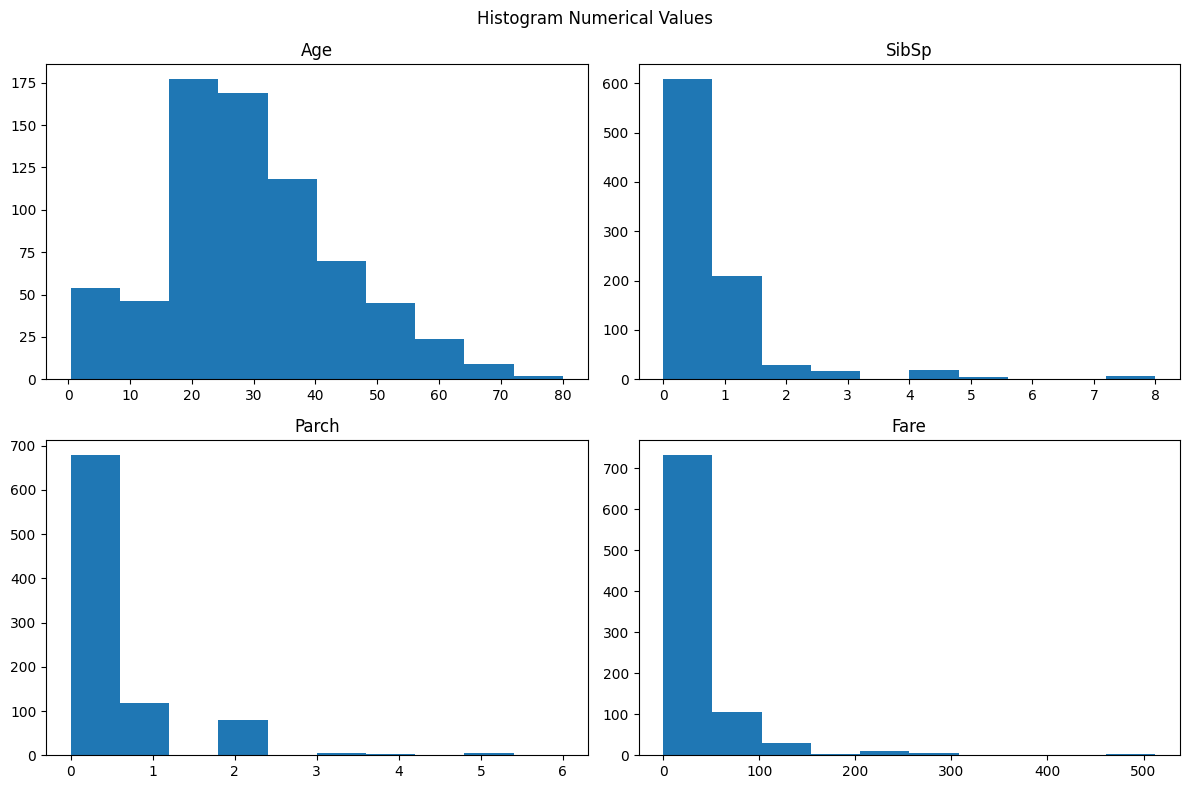

In [427]:
df_num = titanic_data[['Age','SibSp','Parch','Fare']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()
plt.show()

En aquest histogrames de atributs numérics, el que més destaca principalment es la distribució del Fare totalment desproporcionada, encara que també ho estan SibSp i Parch. En el cas de Age, esta bastant bé distribuit.

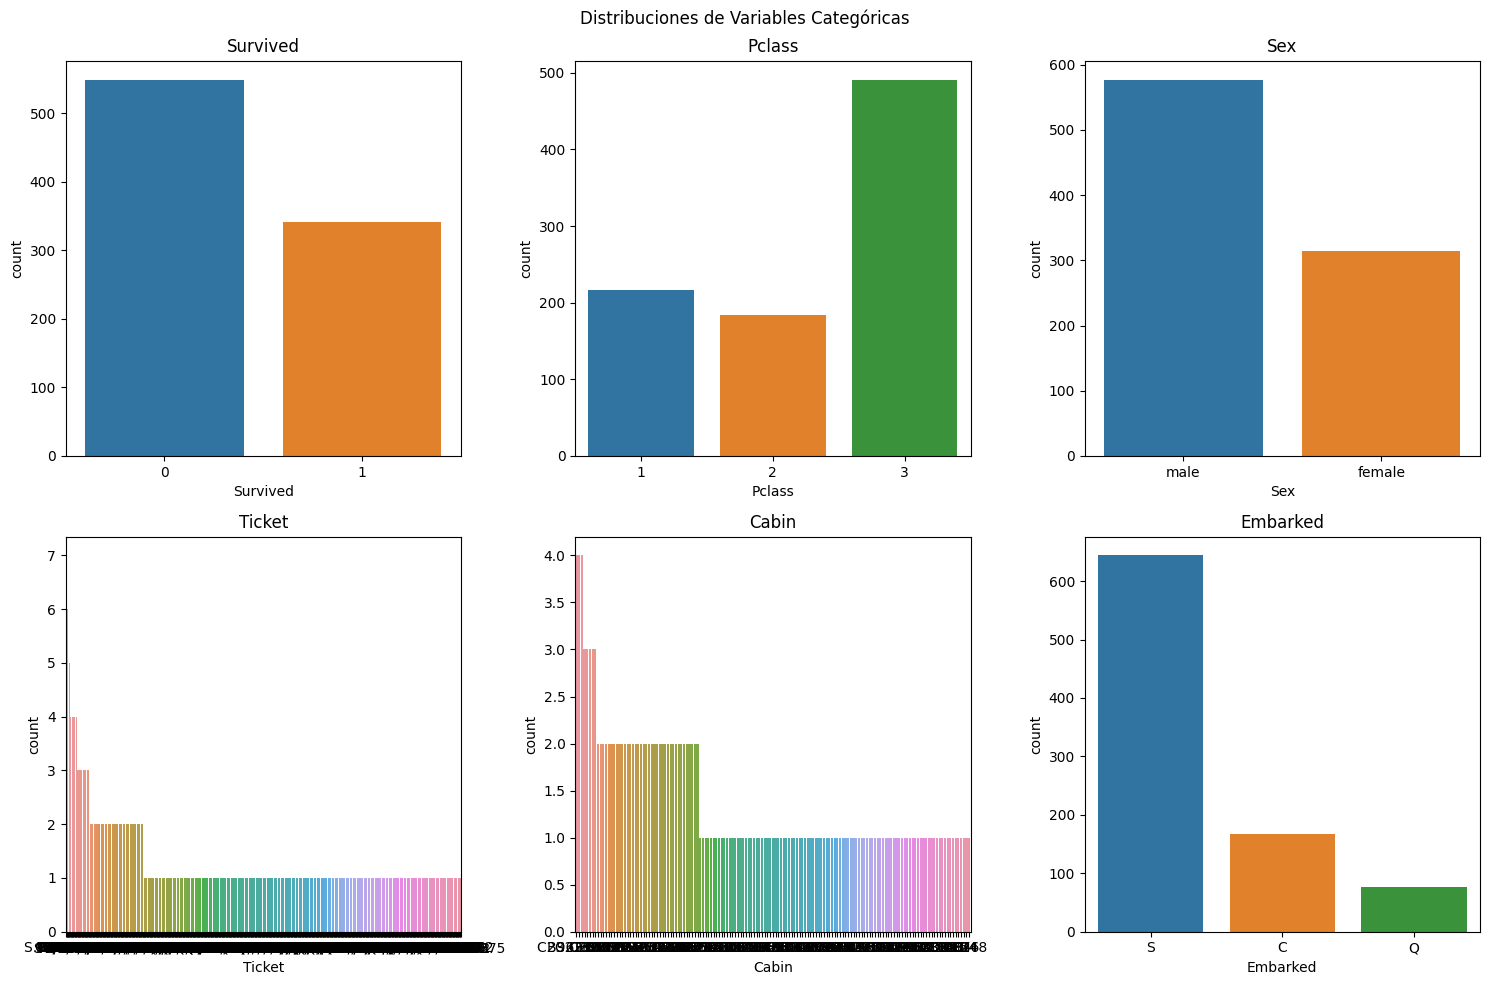

In [428]:
df_cat = titanic_data[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribuciones de Variables Categóricas')

for i, ax in enumerate(axes.ravel()):
    if i < df_cat.shape[1]:
        column_name = df_cat.columns[i]
        sns.barplot(x=df_cat[column_name].value_counts().index, y=df_cat[column_name].value_counts(), ax=ax)
        ax.set_title(column_name)

plt.tight_layout()
plt.show()

Aquesta seria la distribució de cada atribut categòric, inclús el target, on podem veure que a Ticket i Cabin tenen molts valors diferents pel que no ens serveix com per analitzar les correlacions amb survived. Name directament al tenir tot valors únics, no el podem analitzar com aquest altres. En cas de la resta, la distribució mostra una classe predominant sempre. Per exemple, a Survived i a més No-Survived que Survived, que té sentit. A Pclass la classe 3 és la més normal, es a dir, persones que han pujat al vaixell en tercera classe. Els hombres també predominaven i la majoria va embarcar a Southampton. En aquests casos, a diferencia de les numèriques, no afectaria en gran mesura a la classificació perquè tenen valors no molt diferents, excepte Embarked.

Pel cas de les correlacions, mirarem primer las variables númeriques.

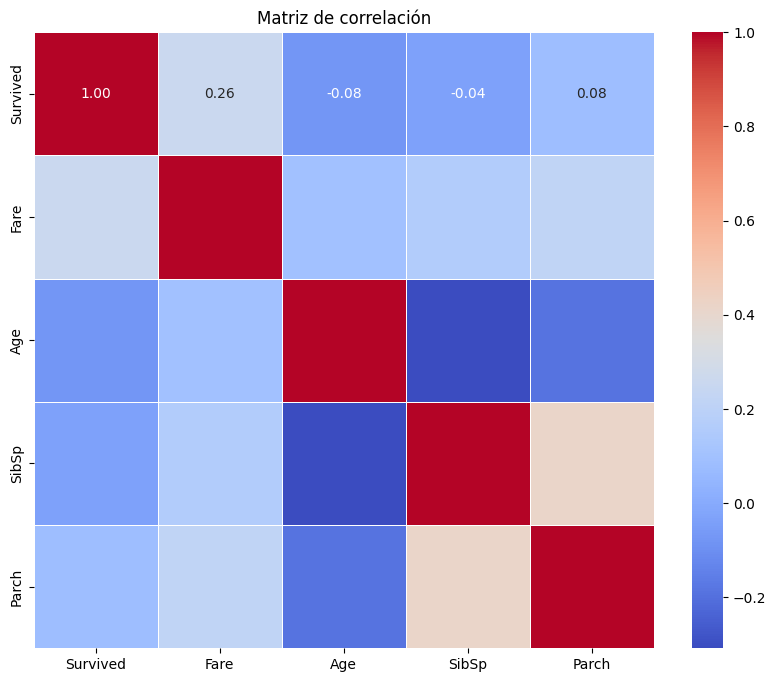

In [429]:
correlation_matrix = titanic_data[['Survived', 'Fare', 'Age', 'SibSp', 'Parch']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de correlación')
plt.show()

Com volem veure únimcament la correlació que tenen els atributs amb el target, aillarem la primera fila, que ens dona com a resultat el següent:

In [430]:
first_row_correlation = correlation_matrix.iloc[0]
first_row_correlation_matrix = pd.DataFrame([first_row_correlation])
first_row_correlation_matrix

,Survived,Fare,Age,SibSp,Parch
Survived,1.0,0.257307,-0.077221,-0.035322,0.081629


Com podem veure, els atributs numèrics que tenen correlació amb la variable Survived son Fare i Parch. Com tots dos son atributs desproporcionats en quant a dades, pot ser caldrà normalitzar més endavant.

Ara mirarem pel cas de les variables categòriques.

Farem una petita adaptació i la variable Sex la convertirem a binaria per veure millor la correlació entre Survived i aquesta.

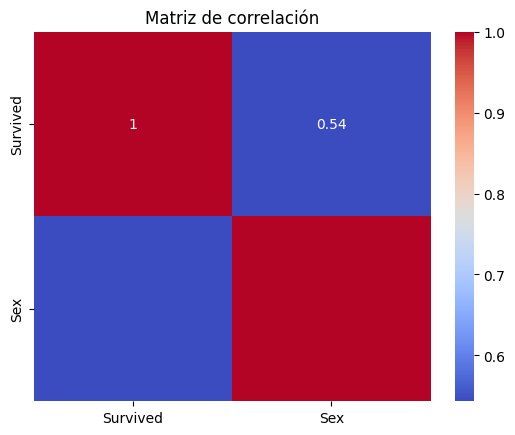

In [431]:
titanic_data["Sex"] = titanic_data["Sex"].replace({"male": 0, "female": 1})

correlation_matrix = titanic_data[['Survived', 'Sex']].corr()
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()
titanic_data["Sex"] = titanic_data["Sex"].replace({0 : "male", 1 : "female"})

A aquesta matriu, podem observar com el Sexe té molta correlació amb el target amb un 0,54. Caldria veure quina es la proporció per cada clase dins d'aquest atribut i tenir-ho en compte més endavant.

Si ho mirem d'altre forma amb altres atributs adicionals, quedaria de la següent forma.

In [432]:
pd.pivot_table(titanic_data, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [433]:
pd.pivot_table(titanic_data, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count')

Sex,female,male
Survived,,
0,81,468
1,233,109


In [434]:
pd.pivot_table(titanic_data, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


Aquestes serien les distribucions dels atributs respecte el target Survived. Veiem la correlació de Sex que vam veure abans on la majoria de 0s corresponen amb homes i la majoria d'1s amb dones. A la resta també es poden observar correlacions com que si ets de classe 3 tens més probabilitats de morir. A Embarked, encara que la majoria de morts es troba a S, esta proporcionat amb la resta de classes, per tant, podem veure que la seva correlació es bastant poca. 

## 2. Preprocessing

En aquest apartat procedirem a realitzar una preparació de les dades pel model.

Començarem amb l'eliminació de NaNs. Com ja vam veure abans, al dataset tenim NaNs a uns quants atributs. Podem decidir que fem amb ells tenint en compte la seva importancia respecte la predicció de Survived.

### NaNs Treatment
#### Cabin

Ara volem veure la relació que té la cabina que tens assignada respecte la teva classe com a passatger (Pclass). Hem fet una cerca a internet i hem vist que la lletra de la cabina era per identificar la planta a on et trobaves i las primeres lletres eran las que es trobaven més a dalt, tenint en compte que la A es la coberta.

In [435]:
titanic_data['cabin_letter'] = titanic_data.Cabin.apply(lambda x: str(x)[0])
pd.pivot_table(titanic_data,index='Pclass',columns='cabin_letter', values = 'Name', aggfunc='count')

cabin_letter,A,B,C,D,E,F,G,T,n
Pclass,,,,,,,,,
1,15.0,47.0,59.0,29.0,25.0,NaN,NaN,1.0,40.0
2,NaN,NaN,NaN,4.0,4.0,8.0,NaN,NaN,168.0
3,NaN,NaN,NaN,NaN,3.0,5.0,4.0,NaN,479.0


Mirant aquesta correlació ens adonem que tenim un únic valor que té assignat la T. La resta dels valors amb aquesta classe són NaNs, per tant, hem decidit obviar-ho i eliminar aquesta única fila. A més que cercant a internet no hem trobat cap cabina que contigui la lletra T, així que suposem que és un error.

La següent funció, emplena els NaNs que trobem a la categoria Cabina (on hi més percentatge de NaNs). No hem considerat la seva eliminació perquè ho considerem un element clau per a la predicció final. Tenim en consideració que quan més alta es la classe, més a dalt et trobaves.

In [436]:
import random
def agregar_probabilidades_planta(dataframe):
    # Función para asignar probabilidades según la clase
    def asignar_planta(row):
        if row['cabin_letter'] != 'n':
            return ord(str(row['cabin_letter'])) - 64
        pclass = row['Pclass']
        if pclass == 1:
            return random.choices([1, 2, 3, 4, 5], weights=[0.05, 0.3, 0.4, 0.15, 0.1])[0]
        elif pclass == 2:
            return random.choices([3, 4, 5, 6], weights=[0.2, 0.3, 0.3, 0.2])[0]
        elif pclass == 3:
            return random.choices([5, 6, 7], weights=[0.2, 0.4, 0.4])[0]

    # Aplicar la función a las filas del DataFrame para obtener la planta asignada
    dataframe['Floor'] = dataframe.apply(asignar_planta, axis=1)
    
    return dataframe

titanic_data['cabin_letter'] = titanic_data.Cabin.apply(lambda x: str(x)[0])

# Llama a la función para agregar la columna
titanic_data = agregar_probabilidades_planta(titanic_data)
titanic_data = titanic_data[titanic_data['Floor'] != 20] # eliminacio del valor únic

# Muestra el DataFrame resultante
print(titanic_data.isna().sum())
pd.pivot_table(titanic_data, index = 'Pclass', columns = 'Floor', values = 'Ticket' ,aggfunc ='count')

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
cabin_letter      0
Floor             0
dtype: int64


Floor,1,2,3,4,5,6,7
Pclass,,,,,,,
1,17.0,57.0,77.0,33.0,31.0,NaN,NaN
2,NaN,NaN,31.0,61.0,36.0,56.0,NaN
3,NaN,NaN,NaN,NaN,101.0,195.0,195.0


El resultat ens mostra com ja omplert les dades, on la suma total ens donarà la quantitat exacta de files que tenim menys una. Per millor comprensió hem canviat las lletres per números i ho hem assignat al atribut Floor. Cabin ja no ens servirà i per tant, ho podrem eliminar.

Com a petita justificació de l'eliminació del Cabin després d'aquest fill podem dir que d'aquesta columna només ens interesava la lletra. El valor numèric no donava res d'informació pel que hem cercat a la web. No tenia relació directa amb la classe o posició dins del titanic, per tant, ja no farem servir més aquesta columna. 

In [437]:
titanic_data = titanic_data.drop(['Cabin', 'cabin_letter'], axis = 1)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 890 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  890 non-null    int64  
 1   Survived     890 non-null    int64  
 2   Pclass       890 non-null    int64  
 3   Name         890 non-null    object 
 4   Sex          890 non-null    object 
 5   Age          713 non-null    float64
 6   SibSp        890 non-null    int64  
 7   Parch        890 non-null    int64  
 8   Ticket       890 non-null    object 
 9   Fare         890 non-null    float64
 10  Embarked     888 non-null    object 
 11  Floor        890 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 90.4+ KB


#### Embarked

La següent columna amb NaNs que tractarem és Embarked on trobem únicament dos a tot el dataset. 

In [438]:
pd.pivot_table(titanic_data,index='Embarked',columns='Pclass', values = 'Ticket', aggfunc='count') 

Pclass,1,2,3
Embarked,,,
C,85,17,66
Q,2,3,72
S,126,164,353


In [439]:
titanic_data[titanic_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Floor
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,2


Al ser els dos nans de la Pclass 1 hem decidit omplir-los amb el valor Embarked C ja que és on per proporció es hi ha més gent de la Pclass 1.

In [440]:
titanic_data.loc[titanic_data['Embarked'].isna(), 'Embarked'] = 'S'
print(titanic_data.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Floor            0
dtype: int64


#### Age
Per últim, farem el fill dels Age. La idea principal d'aquest tractament de NaNs es fer un fill segons una aproximació de edats a partir dels titols dels noms que té cadascú.

In [441]:
titanic_data['name_title'] = titanic_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
nan_counts_by_title = titanic_data.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title

name_title
Capt              0
Col               0
Don               0
Dr                1
Jonkheer          0
Lady              0
Major             0
Master            4
Miss             36
Mlle              0
Mme               0
Mr              119
Mrs              17
Ms                0
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

El que hem fet primer és crear un nou atribut que té com a classes els títols dels nombres que ens servirà per classificar les edats de cadascuna de les persones. Com veiem, tenim un baix percentatge de NaNs a Dr, Master, Miss, Mrs i Ms. Mr té quasi quatre vegades més NaNs que Miss per tant, aplicarem una tècnica de fill diferent.

Pel baix percentatge, l'únic que farem serà omplir amb la mitjà d'edat de les persones que tenen el mateix name_title.

In [442]:
media_por_name_title = titanic_data.groupby('name_title')['Age'].agg(['mean', 'std','count'])
media_por_name_title

,mean,std,count
name_title,,,
Capt,70.000000,NaN,1
Col,58.000000,2.828427,2
Don,40.000000,NaN,1
Dr,42.000000,12.016655,6
Jonkheer,38.000000,NaN,1
Lady,48.000000,NaN,1
Major,48.500000,4.949747,2
Master,4.574167,3.619872,36
Miss,21.773973,12.990292,146


In [443]:
def agregar_probabilidades_edad(dataframe, media_por_name_title):
    # Función para asignar probabilidades según la clase
    def asignar_edad(row):
        if pd.isna(row['Age']) == True and row['name_title'] != 'Mr':
            return round(media_por_name_title['mean'][row['name_title']])
        return row['Age']

    dataframe['Age'] = dataframe.apply(asignar_edad, axis=1)

    return dataframe

titanic_data = agregar_probabilidades_edad(titanic_data, media_por_name_title)

nan_counts_by_title = titanic_data.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title


name_title
Capt              0
Col               0
Don               0
Dr                0
Jonkheer          0
Lady              0
Major             0
Master            0
Miss              0
Mlle              0
Mme               0
Mr              119
Mrs               0
Ms                0
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

Com veiem, hem omplert tots els NaNs que no són de Mr. 

Després, farem una clusterització. Agafarem totes les persones amb name_title = Mr i farem un KNNImputer peromplir els NaNs que ens falten en funció del cluster on es classifica. Aquesta clusterització la farem després de de la normalització i de l'encoding ja que ens servirà per classificar millor els nans de Mr.

Com a resultat, tenim totes les categories omplenades (menys els ages de Mr) segons les relacions que tenen amb la resta de dades i en un contexte correcte amb diferents mètodes que permeten aproximar-nos encara més a un valor que sigui el més realista possible.

El principal motiu de no eliminar cap columna del nostre dataset es per no perdre posibles relacions entre categories que porten a un millor rendiment del nostre model. Encara que la quantiat de NaNs sigui molt petita, per entrenar millor el model, ens convé no el·liminar les files ni les columnes amb un gran percentatge de missing values ja que perdem dades importants.   

### Feature Selection

Altre procediment important abans de realitzar l'entrenament dels nostres models és la selecció de característiques. Dins del nostre dataset n'hi han columnes de dades que són totalment irrellevants per l'aprenentatge del classificador. Una d'aquestes és la de PassengerId on únicament s'ens informa del index de la mostra sense cap correlació amb qualsevol altra dada del dataset. No obstant, altres característiques caldria especificar en detall perquè són el·liminades.

Anem a veure la posible correlació entre l'atribut Ticket i Survived. Al ser una variable categòrica ens fixarem en si que tiquet està format per números només o per números i lletres i veurem els resultats. En cas de que no ens aporti informació nova, eliminarem la columna Ticket ja que no ens servirà per al nostre model.

In [448]:
titanic_data['Numerical_ticket'] = titanic_data.Ticket.apply(lambda x: 1 if x.isdigit() else 0)
pd.pivot_table(titanic_data,index='Numerical_ticket',columns='Survived', values = 'Ticket', aggfunc='count')

Survived,0,1
Numerical_ticket,,
0,142,88
1,406,254


Com podiem intuir, la relació entre Numerical_ticket i Survived no ens aporta molta informació ja que als dos possibles casos, els resultats són proporcionals. Això vol dir que per al nostre model la variable Ticket no ens ajudarà a predir millor i la eliminarem per així aconseguir reduir la dimensionalitat del dataset i que sigui menys complexe.

Finalment també hem decidit eliminar la variable Name, ja que, els noms complets no són gens rellevants però el que si que ens quedarem serà amb el Name_title que ens aporta més informació que l'altre característica.

In [449]:
titanic_data = titanic_data.drop(['Ticket', 'Name', 'PassengerId', 'Numerical_ticket'], axis=1)

In [450]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 890 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    890 non-null    int64  
 1   Pclass      890 non-null    int64  
 2   Sex         890 non-null    object 
 3   Age         771 non-null    float64
 4   SibSp       890 non-null    int64  
 5   Parch       890 non-null    int64  
 6   Fare        890 non-null    float64
 7   Embarked    890 non-null    object 
 8   Floor       890 non-null    int64  
 9   name_title  890 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 76.5+ KB


### Normalitzacion

"La normalización logarítmica se usa para transformar datos con distribuciones sesgadas o amplia variabilidad, reduciendo el sesgo y la amplitud de valores. Ayuda a nivelar la distribución, estabilizar la varianza, facilitar la interpretación y preparar datos para ciertos modelos, pero su aplicabilidad depende de la naturaleza de los datos y del contexto del problema."

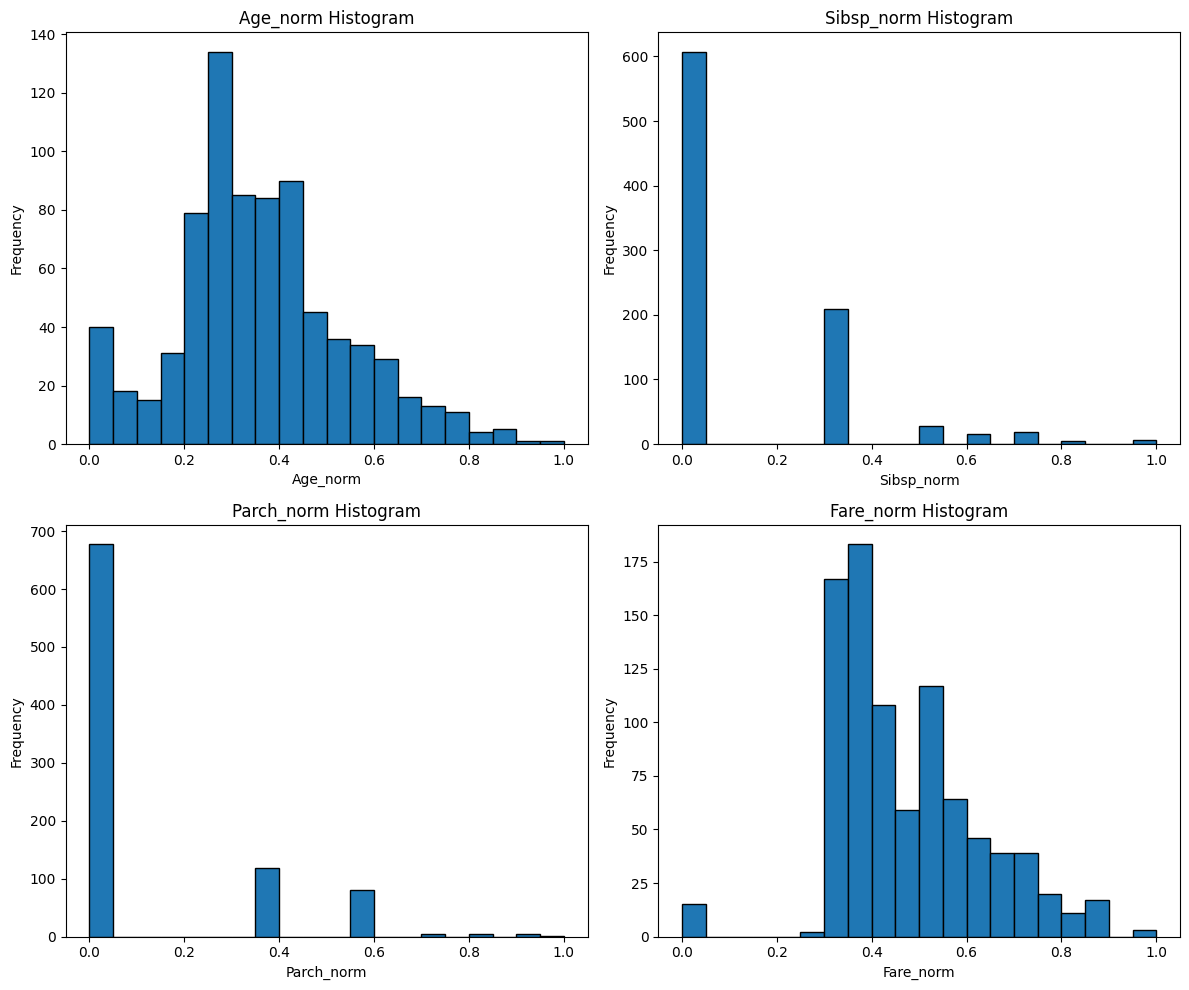

In [451]:
titanic_data['Fare_norm'] = np.log1p(titanic_data.Fare)

titanic_data['Parch_norm'] = np.log1p(titanic_data.Parch)

titanic_data['Sibsp_norm'] = np.log1p(titanic_data.SibSp)

titanic_data['Age_norm'] = titanic_data.Age

scaler = MinMaxScaler()
titanic_data[['Age_norm', 'Sibsp_norm', 'Fare_norm', 'Parch_norm']] = scaler.fit_transform(titanic_data[['Age_norm', 'Sibsp_norm', 'Fare_norm', 'Parch_norm']])
titanic_data.isna().sum()

plt.figure(figsize=(12, 10))

# Primer histograma
plt.subplot(2, 2, 1)
plt.hist(titanic_data['Age_norm'], bins=20, edgecolor='k')
plt.title('Age_norm Histogram')
plt.xlabel('Age_norm')
plt.ylabel('Frequency')

# Segundo histograma
plt.subplot(2, 2, 2)
plt.hist(titanic_data['Sibsp_norm'], bins=20, edgecolor='k')
plt.title('Sibsp_norm Histogram')
plt.xlabel('Sibsp_norm')
plt.ylabel('Frequency')

# Tercer histograma
plt.subplot(2, 2, 3)
plt.hist(titanic_data['Parch_norm'], bins=20, edgecolor='k')
plt.title('Parch_norm Histogram')
plt.xlabel('Parch_norm')
plt.ylabel('Frequency')

# Cuarto histograma
plt.subplot(2, 2, 4)
plt.hist(titanic_data['Fare_norm'], bins=20, edgecolor='k')
plt.title('Fare_norm Histogram')
plt.xlabel('Fare_norm')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

titanic_data = titanic_data.drop(['Age','SibSp', 'Parch', 'Fare'], axis=1)


In [452]:
titanic_data

,Survived,Pclass,Sex,Embarked,Floor,name_title,Fare_norm,Parch_norm,Sibsp_norm,Age_norm
0,0,3,male,S,7,Mr,0.338125,0.000000,0.315465,0.271174
1,1,1,female,C,3,Mrs,0.685892,0.000000,0.315465,0.472229
2,1,3,female,S,7,Miss,0.350727,0.000000,0.000000,0.321438
3,1,1,female,S,3,Mrs,0.639463,0.000000,0.315465,0.434531
4,0,3,male,S,7,Mr,0.352955,0.000000,0.000000,0.434531
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,S,6,Rev,0.422864,0.000000,0.000000,0.334004
887,1,1,female,S,2,Miss,0.550238,0.000000,0.000000,0.233476
888,0,3,female,S,6,Miss,0.512205,0.564575,0.315465,0.271174
889,1,1,male,C,3,Mr,0.550238,0.000000,0.000000,0.321438


### Encoding

Per poder entrenar sense problemes el model haurem de fer encoding a les variables categòriques. Les que tenim són: Embarked, Name_title, PClass, Floor i Sex. Hem de buscar una bona forma de fer encoding per obtenir un bon rendiment al model.

Per realitzar aquesta tasca hem de pensar quin encoder utilitzar. Al observar les dades ens en adonem que no segueixen cap ordre intrinsic, aleshores hem d'utilitzar la codificació One Hot Encoder, sinó el model interpretaria malament les dades i obtindriem un mal rendiment. One Hot Encoder ens afegeix una columna nova per cadascuna de les classes de la columna codificada i posa un 1 a la fila que correspon amb la categoria. Encara que augmenta la dimensionalitat de les dades, creime que es la millor opció.

In [453]:
titanic_data_RF = titanic_data.copy()

categorical_attributes = ['name_title', 'Embarked', 'Sex', 'Floor', 'Pclass']

for attribute in categorical_attributes:
    encoder = OneHotEncoder(sparse=False)
    attribute_encoded = encoder.fit_transform(titanic_data[[attribute]])

    new_column_names = encoder.get_feature_names_out(input_features=[attribute])
    encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=titanic_data.index)

    titanic_data = titanic_data.drop([attribute], axis=1)
    titanic_data = pd.concat([titanic_data, encoded_df], axis=1)

titanic_data

,Survived,Fare_norm,Parch_norm,Sibsp_norm,Age_norm,name_title_Capt,name_title_Col,name_title_Don,name_title_Dr,name_title_Jonkheer,...,Floor_1,Floor_2,Floor_3,Floor_4,Floor_5,Floor_6,Floor_7,Pclass_1,Pclass_2,Pclass_3
0,0,0.338125,0.000000,0.315465,0.271174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0.685892,0.000000,0.315465,0.472229,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,0.350727,0.000000,0.000000,0.321438,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0.639463,0.000000,0.315465,0.434531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.352955,0.000000,0.000000,0.434531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.422864,0.000000,0.000000,0.334004,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
887,1,0.550238,0.000000,0.000000,0.233476,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
888,0,0.512205,0.564575,0.315465,0.271174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
889,1,0.550238,0.000000,0.000000,0.321438,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Podem veure que ha afegit 27 columnes noves que corresponen amb cadascuna de les classes de la categoria name_title, PClass, Sex, Floor i Embarked. Per tant, com ja hem encoding a les variables categoriques, ja no hi haurà problemes alhora de entrenar el model, encara que classificadors com Random Forest admeten variables categoriques.

Al utilitzar One Hot Encoder, la interpretació dels arbres pot estar afectada. Es per això que hem creat una copia del dataset titanic_data sense fer la transformació per més tard utilitzar al Model Selection aquest dataset i entrenar el model amb Random Forest.

Finalment ara farem el KNNImputer per acabar d'omplir els nans de els ages de Mr.

In [454]:
imputer = KNNImputer(n_neighbors=5)

X_imputed = imputer.fit_transform(titanic_data)

titanic_data = pd.DataFrame(X_imputed, columns=titanic_data.columns)

In [455]:
titanic_data.isna().sum()

Survived                   0
Fare_norm                  0
Parch_norm                 0
Sibsp_norm                 0
Age_norm                   0
name_title_Capt            0
name_title_Col             0
name_title_Don             0
name_title_Dr              0
name_title_Jonkheer        0
name_title_Lady            0
name_title_Major           0
name_title_Master          0
name_title_Miss            0
name_title_Mlle            0
name_title_Mme             0
name_title_Mr              0
name_title_Mrs             0
name_title_Ms              0
name_title_Rev             0
name_title_Sir             0
name_title_the Countess    0
Embarked_C                 0
Embarked_Q                 0
Embarked_S                 0
Sex_female                 0
Sex_male                   0
Floor_1                    0
Floor_2                    0
Floor_3                    0
Floor_4                    0
Floor_5                    0
Floor_6                    0
Floor_7                    0
Pclass_1      

## 3. Metric selection 

Per a mesurar la qualitat d'un model tenim diferents mètriques. 
- **Accuracy**: Mesura la proporció de prediccions correctes en comparació amb el total de prediccions. És una mètrica adequada quan les classes estan balancejades i totes les classes són igualment importants. No obstant això, en casos de classes desbalancejades, la precisió pot ser enganyosa, ja que un model que prediu sempre la classe majoritària podria tenir una alta precisió però no ser útil en la pràctica.

- **F1-SCORE**: És una mètrica que combina la precisió i el recall. L'F1-score és útil quan tens un desequilibri en les classes o quan estàs més interessat en l'equilibri entre les prediccions correctes de totes dues classes (veritables positius) i en minimitzar tant els falsos positius com els falsos negatius. És especialment útil en problemes de detecció d'anomalies o en aquells en què una classe és més important que l'altre.

- **Average_presicion_score**: Mesura la precisió mitjana d'un model en la recuperació de totes les classes. És especialment útil quan et preocupen les taxes de falsos positius i veritables positius en problemes de recuperació d'informació o classificació de documents, on cal donar prioritat a la recuperació d'elements rellevants.

Dit això per a l'avaluació del nostre model ens quedarem amb la F1-score ja que al tenir dades desbalancejades el accuracy no ens interessa tant. També volem tenir equilibri entre les prediccions correctes de totes dues classes ja que al estar predint si es sobreviurà o no (estem parlant de vides humanes) volem minimitzar els falsos positius i negatius, cosa que no es valora en el average_presicion_score. 

Average_precision_score:  0.697336834154469 

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       548
         1.0       0.80      0.75      0.77       342

    accuracy                           0.83       890
   macro avg       0.83      0.82      0.82       890
weighted avg       0.83      0.83      0.83       890



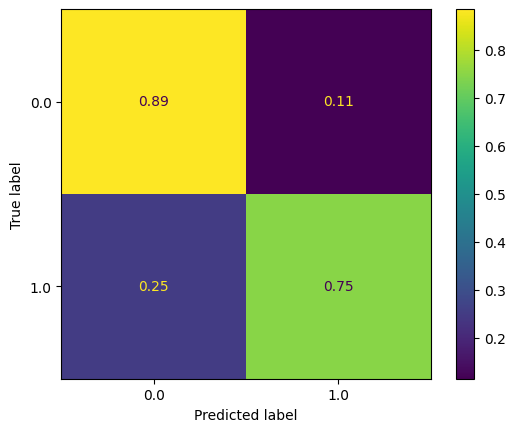

In [456]:
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']

model = LogisticRegression()

model.fit(X, y)
y_pred = model.predict(X)

accuracy = accuracy_score(y, y_pred)
confusion = ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true')
report = classification_report(y, y_pred)
average_precision = average_precision_score(y, y_pred)
print("Average_precision_score: ", average_precision, '\n')
print("Informe de Clasificación:")
print(report)

Podem observar com la funció classification_report ens mostra les mètriques accuracy, presicion, recall i f1-score, útils en l'avaluació del model. Com em deit abans ens centrarem sobretot en la f1-score pero això no treu que ens interessi veure tmb les mètriques accuracy i presicion.  
Per tal d'optimitzar el problema com hem dit abans ens fixarem en la f1-score que és un equilibri entre la presicion i la recall.

Altres maneres d'avaluar un model és fent servir les curves ROC i PR.
- **PR-CURVE**: La corba de precisió-recall és especialment rellevant en situacions en què l'equilibri de les classes és significatiu. En el context del Titanic, on la majoria dels passatgers no va sobreviure, aquesta mètrica és important. La corba de precisió-recall representa la relació entre la precisió i el recall a mesura que varies el llindar de decisió del model. La precisió mesura la proporció de prediccions positives que són correctes, mentre que el recall mesura la proporció d'exemples positius que es capturen correctament. En general, si et preocupa més minimitzar els falsos negatius (classificar incorrectament els supervivents), la corba de precisió-recall és més rellevant.  
- **ROC-CURVE**: La corba ROC (Receiver Operating Characteristic) és útil per mesurar la capacitat d'un model per distingir entre les classes en funció de la taxa de veritables positius i la taxa de falsos positius. Mesura com canvia la taxa de veritables positius a mesura que varies el llindar de decisió. Al Titanic, la corba ROC també és rellevant, especialment si estàs interessat en la capacitat del teu model per classificar correctament els passatgers supervivents i no supervivents en un rang de llindars. No obstant això, en un conjunt de dades desequilibrat, la corba ROC pot ser menys informativa en comparació amb la corba de precisió-recall.

La diferència clau entre les dues mètriques rau en com tracten els falsos positius. La corba de precisió-recall se centra en la capacitat del model per minimitzar els falsos positius i s'utilitza quan la classe positiva és més important. D'altra banda, la corba ROC avalua la capacitat del model per distingir entre les classes sense donar preferència a cap en particular i pot ser més adequada en situacions on les taxes de falsos positius i veritables positius són igualment importants.  

En resum, en el nostre cas, donat que l'equilibri de les classes és un factor important i sovint és crucial identificar correctament els supervivents, és probable que la corba de precisió-recall sigui més rellevant. No obstant això, sempre és útil examinar les dues corbes per comprendre completament el rendiment del model i ajustar el llindar de decisió segons les teves necessitats específiques.

Funcions per a mostrar les corbes ROC i PR.

In [457]:
def print_ROC_curve(y ,y_pred):
    roc_score = roc_auc_score(y, y_pred)

    print('ROC AUC=%.3f' % (roc_score))

    ns = [0 for _ in range(len(y))]

    lr_fpr, lr_tpr, _ = roc_curve(y, y_pred)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sense capacitat predictiva')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
    plt.ylabel('Recall')
    plt.xlabel('Specificity')
    
def print_PR_curve(y, y_pred):
    precision, recall, _ = precision_recall_curve(y, y_pred)

    print("Presició: ", precision[1], '\n')
    print("Recall: ", recall[1], '\n')

    area_under_curve = auc(recall, precision)

    plt.plot(recall, precision, marker='.',)
    plt.xlabel('Recall')
    plt.ylabel('Precision')


#### Corba ROC

ROC AUC=0.817


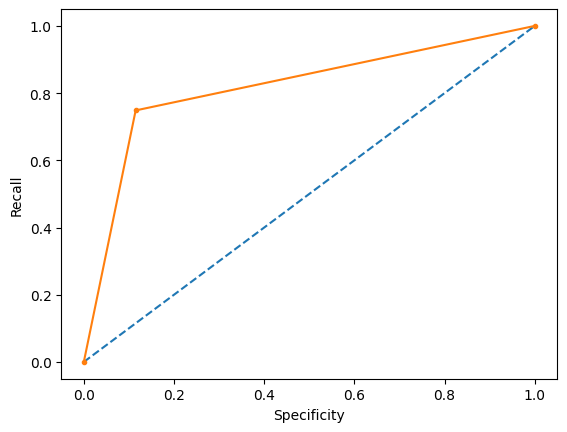

In [458]:
print_ROC_curve(y, y_pred)

#### Corba PR

Presició:  0.8025078369905956 

Recall:  0.7485380116959064 



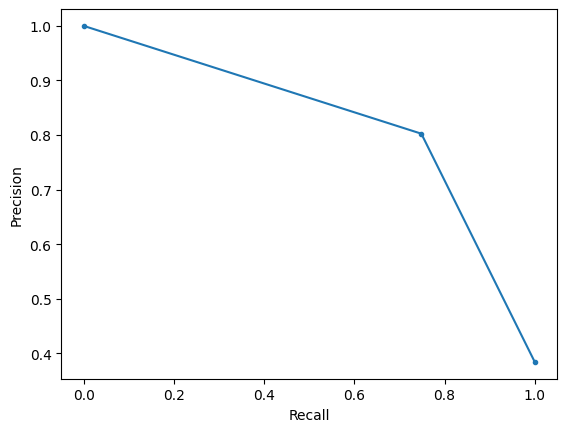

In [459]:
print_PR_curve(y, y_pred)

## 4. Model Selection amb validacio creuada

En aquest apartat entrenarem 4 models diferents de classificació (LogisticRegression, SVM, KNN i RandomForest) i els avaluarem segons la mètrica de f1-score per a quedar-nos amb el millor.  
Per entrenar-los farem servir el cross validation i posteriorment farem una cerca d'hiperparàmetres per a que els models puguin ser el mes presicos posibles per al nostre cas.

És important fer servir la validació creuada al entrenament dels models per evitar possibles overfittings, ja que al estar desbalancejat el dataset, una partició errònia al fer el entrenament ens portaria a resultats no desitjats.  
Concretament farem servir el k-fold cv el qual fa k particions del dataset entrenant el model amb les k particions i fent la mitja per a quedar-se amb el resultat final.

Entrenament dels models amb cross validation amb els hyperparametres per defecte.

In [474]:
f1_scores = {'Sense hyperparametres':{'KNN' : 0, 'SVM' : 0, 'LR' : 0, 'RF' : 0}, 'Amb hyperparametres' : {'KNN' : 0, 'SVM' : 0, 'LR' : 0, 'RF' : 0}}

- KNN

In [475]:
knn = KNeighborsClassifier()
score_knn = cross_val_score(knn, X, y, scoring='f1')
f1_scores['Sense hyperparametres']['KNN'] = score_knn

- SVM

In [476]:
svm = SVC()
score_svm = cross_val_score(svm, X, y, scoring='f1')
f1_scores['Sense hyperparametres']['SVM'] = score_svm

- Logistic Regression

In [477]:
lr = LogisticRegression()
score_lr = cross_val_score(lr, X, y, scoring='f1')
f1_scores['Sense hyperparametres']['LR'] = score_lr

- RF

In [478]:
rf = RandomForestClassifier()
score_rf = cross_val_score(rf, X, y, scoring='f1')
f1_scores['Sense hyperparametres']['RF'] = score_rf

In [495]:
medias = {k:{model:np.array(scores).mean() for model, scores in v.items()} for k,v in f1_scores.items()}
print(medias)

{'Sense hyperparametres': {'KNN': 0.7490608054280508, 'SVM': 0.7393716945081668, 'LR': 0.7564308664764916, 'RF': 0.7387314272525316}, 'Amb hyperparametres': {'KNN': 0.0, 'SVM': 0.0, 'LR': 0.0, 'RF': 0.0}}


Cerca d'hyperparametres